In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


In [3]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
from sympy import expand


df['new_Cabin_Flag'] = df['Cabin'].notnull().astype('int')
df['new_name_word_count'] = df['Name'].apply(lambda x: len(str(x).split(" ")))
df['new_name_count'] = df['Name'].str.len()
df['new_name_dr'] = df['Name'].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df['new_title'] = df.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
df["new_family_size"] = df["SibSp"] + df["Parch"] + 1

df["new_age_pclass"] = df["Age"] * df["Pclass"]

df.loc[((df['SibSp'] + df['Parch']) > 0), "new_is_alone"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "new_is_alone"] = "YES"

df.loc[(df['Age'] < 18), 'new_age_cat'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 56), 'new_age_cat'] = 'mature'
df.loc[(df['Age'] >= 56), 'new_age_cat'] = 'senior'

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'new_sex_cat'] = 'youngmale'
df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'new_sex_cat'] = 'maturemale'
df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'new_sex_cat'] = 'seniormale'
df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'new_sex_cat'] = 'youngfemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'new_sex_cat'] = 'maturefemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'new_sex_cat'] = '0seniorfemale'

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,new_Cabin_Flag,new_name_word_count,new_name_count,new_name_dr,new_title,new_family_size,new_age_pclass,new_is_alone,new_age_cat,new_sex_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,4,23,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,7,51,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,3,22,0,Miss,1,78.0,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,7,44,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,4,24,0,Mr,1,105.0,YES,mature,maturemale


In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alinmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sinif eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sinif eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit



def find_outliers(dataframe,col_name,q1=0.25,q3=0.75):
    q1 = dataframe[col_name].quantile(q1)
    q3 = dataframe[col_name].quantile(q3)
    interquantile_range = q3 - q1
    up_limit = q3 + 1.5 * interquantile_range
    low_limit = q1  - 1.5 * interquantile_range
    mask = dataframe[((dataframe[col_name]< low_limit) | (dataframe[col_name] > up_limit))]
    if mask.any(axis=None):
        print(f"Outliers_index:{mask.index}")
        print("-"*70)
        print(f"Outliers_value:{mask}")
        return up_limit, low_limit, mask, q1, q3, interquantile_range
    else:
        return False
    

def analysis_outliers(dataframe, col_name, index=False):
    up_limit, low_limit, mask, q1, q3, interquantile_range = find_outliers(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].head())
    else:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))])
    
    if index:
        outlier_index = mask.index
        return outlier_index
    
def remove_outliers(dataframe,col_name):
    up_limit, low_limit, mask, q1, q3, interquantile_range= find_outliers(dataframe,col_name)
    dataset_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return dataset_without_outliers

In [9]:
for col in num_cols:
    print(col, find_outliers(df,col))

PassengerId False
Outliers_index:Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')
----------------------------------------------------------------------
Outliers_value:     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1       

In [10]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [11]:
for col in num_cols:
    replace_with_thresholds(df,col)

for col in num_cols:
    print(col, find_outliers(df,col))

PassengerId False
Age False
Fare False
new_name_count False
new_age_pclass False


In [12]:
def missing_values_first_look(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    miss_n = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_values_df = pd.concat([miss_n, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_values_df)

    if na_name:
        return na_cols
def missing_graphs(df):
    msno.bar(df)
    msno.heatmap(df)
    msno.matrix(df)
    plt.show()

In [13]:
missing_values_first_look(df)

                n_miss  ratio
Cabin              687  77.10
Age                177  19.87
new_age_pclass     177  19.87
new_age_cat        177  19.87
new_sex_cat        177  19.87
Embarked             2   0.22


In [14]:
df.drop(["Cabin","Ticket","Name"],inplace=True,axis=1)

In [15]:
df['Age'] = df['Age'].fillna(df.groupby('new_title')['Age'].transform("median"))
missing_values_first_look(df)

                n_miss  ratio
new_age_pclass     177  19.87
new_age_cat        177  19.87
new_sex_cat        177  19.87
Embarked             2   0.22


In [16]:
df["new_age_pclass"] = df["Age"] * df["Pclass"]

df.loc[(df['Age'] < 18), 'new_age_cat'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 56), 'new_age_cat'] = 'mature'
df.loc[(df['Age'] >= 56), 'new_age_cat'] = 'senior'

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'new_sex_cat'] = 'youngmale'
df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'new_sex_cat'] = 'maturemale'
df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'new_sex_cat'] = 'seniormale'
df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'new_sex_cat'] = 'youngfemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'new_sex_cat'] = 'maturefemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'new_sex_cat'] = 'seniorfemale'


In [17]:
missing_values_first_look(df)

          n_miss  ratio
Embarked       2   0.22


In [18]:
from enum import unique
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique())<=10) else x, axis=0)
missing_values_first_look(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [19]:
def label_encoder_to_dataframe(dataframe,binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [20]:
from numpy import float64, int64


binary_cols = []
for col in df.columns:
    if df[col].dtype not in [int64, float64] and df[col].nunique() == 2:
        binary_cols.append(col)

In [21]:
binary_cols

['Sex', 'new_Cabin_Flag', 'new_is_alone']

In [22]:
for col in binary_cols:
   label_encoder_to_dataframe(df,col)

In [23]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,new_Cabin_Flag,new_name_word_count,new_name_count,new_name_dr,new_title,new_family_size,new_age_pclass,new_is_alone,new_age_cat,new_sex_cat
0,1.0,0,3,1,22.0,1,0,7.2500,S,0,4,23.0,0,Mr,2,66.0,0,mature,maturemale
1,2.0,1,1,0,38.0,1,0,65.6344,C,1,7,45.0,0,Mrs,2,38.0,0,mature,maturefemale
2,3.0,1,3,0,26.0,0,0,7.9250,S,0,3,22.0,0,Miss,1,78.0,1,mature,maturefemale
3,4.0,1,1,0,35.0,1,0,53.1000,S,1,7,44.0,0,Mrs,2,35.0,0,mature,maturefemale
4,5.0,0,3,1,35.0,0,0,8.0500,S,0,4,24.0,0,Mr,1,105.0,1,mature,maturemale


In [24]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"Count": dataframe[col].value_counts(),"Ratio": dataframe[col].value_counts()/len(dataframe),"Target Mean": dataframe.groupby(col)[target].mean()}))


def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and (temp_df[col].value_counts() / len(temp_df)< rare_perc).any(axis=None)]
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df



In [25]:
rare_analyser(df,"Survived",cat_cols)

Sex : 2
   Count     Ratio  Target Mean
0    314  0.352413     0.742038
1    577  0.647587     0.188908
Embarked : 3
   Count     Ratio  Target Mean
C    168  0.188552     0.553571
Q     77  0.086420     0.389610
S    646  0.725028     0.339009
new_title : 17
          Count     Ratio  Target Mean
Capt          1  0.001122     0.000000
Col           2  0.002245     0.500000
Countess      1  0.001122     1.000000
Don           1  0.001122     0.000000
Dr            7  0.007856     0.428571
Jonkheer      1  0.001122     0.000000
Lady          1  0.001122     1.000000
Major         2  0.002245     0.500000
Master       40  0.044893     0.575000
Miss        182  0.204265     0.697802
Mlle          2  0.002245     1.000000
Mme           1  0.001122     1.000000
Mr          517  0.580247     0.156673
Mrs         125  0.140292     0.792000
Ms            1  0.001122     1.000000
Rev           6  0.006734     0.000000
Sir           1  0.001122     1.000000
new_is_alone : 2
   Count     Ratio  T

In [26]:
df = rare_encoder(df, 0.01)
df["new_title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: new_title, dtype: int64

In [27]:
def one_hot_encoder(dataframe,  categorical_data, drop_first=True):
    dataframe = pd.get_dummies(dataframe,columns=categorical_data,drop_first=drop_first)
    return dataframe

In [28]:
oh_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, oh_cols)

df.head()
df.shape


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

rare_analyser(df, "Survived", cat_cols)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47
Survived : 2
   Count     Ratio  Target Mean
0    549  0.616162            0
1    342  0.383838            1
Sex : 2
   Count     Ratio  Target Mean
0    314  0.352413     0.742038
1    577  0.647587     0.188908
new_Cabin_Flag : 2
   Count     Ratio  Target Mean
0    687  0.771044     0.299854
1    204  0.228956     0.666667
new_name_dr : 2
   Count     Ratio  Target Mean
0    881  0.988777      0.38252
1     10  0.011223      0.50000
new_is_alone : 2
   Count     Ratio  Target Mean
0    354  0.397306     0.505650
1    537  0.602694     0.303538
Pclass_2 : 2
   Count    Ratio  Target Mean
0    707  0.79349     0.360679
1    184  0.20651     0.472826
Pclass_3 : 2
   Count     Ratio  Target Mean
0    400  0.448934     0.557500
1    491  0.551066     0.242363
SibSp_1 : 2
   Count     Ratio  Target Mean
0    682  0.765432     0.337243
1    209  0.234568     0.535885
SibSp_2 : 2
   Count     Ratio  Targ

In [29]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

useless_cols

['SibSp_5',
 'SibSp_8',
 'Parch_3',
 'Parch_4',
 'Parch_5',
 'Parch_6',
 'new_name_word_count_9',
 'new_name_word_count_14',
 'new_family_size_8',
 'new_family_size_11']

In [30]:
df.drop(useless_cols, axis=1, inplace=True)

In [31]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,PassengerId,Age,Fare,new_name_count,new_age_pclass
0,-1.730108,-0.560638,-0.820552,-0.436675,0.066488
1,-1.726220,0.663302,2.031623,2.248303,-0.790429
2,-1.722332,-0.254653,-0.787578,-0.558720,0.433739
3,-1.718444,0.433813,1.419297,2.126258,-0.882241
4,-1.714556,0.433813,-0.781471,-0.314631,1.260052


In [32]:
y = df["Survived"]
X = df.drop(["Survived"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
from telnetlib import PRAGMA_HEARTBEAT
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(accuracy_score(y_pred, y_test), accuracy_score(y_pred_train,y_train))
print("Overfittttt")

0.8171641791044776 1.0
Overfittttt


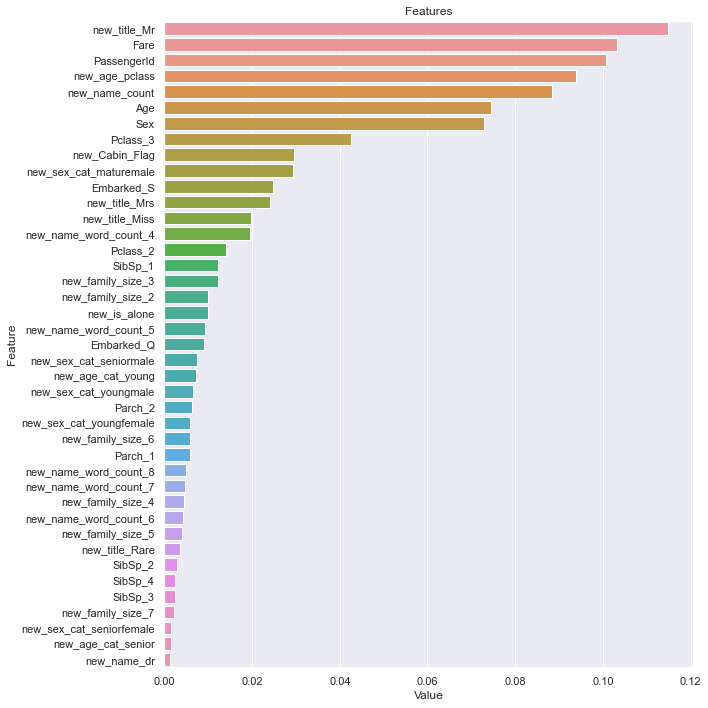

In [33]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf, X_train)
